In [19]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [35]:
our_color_palette = {"WT": "#F2C14E", # yellow
                     "W": "#F2C14E", # yellow
                     "IP": "#79ADDC", # blue
                     "I": "#79ADDC", # blue
                     "KO": "#B279A7", # purple
                     "K": "#B279A7", # purple
                    } 
treatments_list = ["W", "I", "K"]
passages_list = ["p1", "p2", "p3", "p5", "p10"]
replicates_list = ['a', 'b', 'c']

In [96]:
df = pd.read_csv("../../resources/additional_data/titers.formated.csv")

# log-transform titer values to "normalize" data distribution 
df["log_titer"] = np.log(df['titer'])
df['rep'] = df['genotype'] + df['replicate']

df.head(5)

,virus,passage,genotype,replicate,titer,log_titer,rep
0,crpv,1,WT,a,3.160000e+08,19.571253,WTa
1,crpv,2,WT,a,4.640000e+09,22.257980,WTa
2,crpv,3,WT,a,4.640000e+09,22.257980,WTa
3,crpv,4,WT,a,3.160000e+09,21.873838,WTa
4,crpv,5,WT,a,4.640000e+09,22.257980,WTa


In [97]:
df.columns

Index(['virus ', 'passage', 'genotype', 'replicate', 'titer', 'log_titer',
       'rep'],
      dtype='object')

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_2535/2028827315.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.barplot(


<AxesSubplot: xlabel='passage', ylabel='log_titer'>

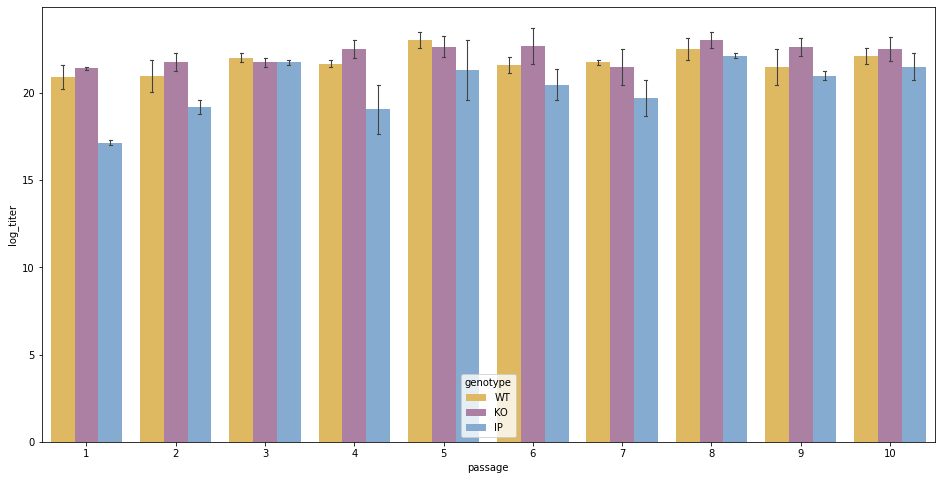

In [98]:
fig, ax = plt.subplots(1,1,  sharey=True, figsize=(16,8))

sns.barplot(
    data=df[df['virus ']=='crpv'], 
    hue='genotype', 
    x='passage', 
    palette=our_color_palette,
    y='log_titer',
    errwidth=1.1, 
    errorbar="se",
    dodge=0.2,
    capsize=0.1
)

In [40]:
df_crpv = df[df['virus ']=='crpv']
df_dcv = df[df['virus ']=='dcv']

In [70]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## crpv

In [71]:
%%R -i df_crpv 



df_crpv$passage <- as.factor(df_crpv$passage)

# Convert genotype to factor
df_crpv$genotype <- factor(df_crpv$genotype)

# Relevel the genotype factor with W as reference
df_crpv$genotype <- relevel(df_crpv$genotype, ref = "WT")



/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [87]:
%%R 

# use mixed ANOVA
# within-subject factor: passage
# indepentent between factor: genotype 
# dependent variable: dcv titers

library(rstatix)

# Two-way mixed ANOVA test
res.aov <- anova_test(
  data = df_crpv, 
    dv = log_titer, 
    wid = rep,
    between = genotype, 
    within = passage
  )
get_anova_table(res.aov)

ANOVA Table (type II tests)

            Effect DFn DFd      F        p p<.05   ges
1         genotype   2   6 65.385 8.44e-05     * 0.403
2          passage   9  54  3.860 7.98e-04     * 0.384
3 genotype:passage  18  54  0.980 4.95e-01       0.240


In [86]:
%%R 

# use mixed ANOVA
# within-subject factor: passage
# indepentent between factor: genotype 
# dependent variable: dcv titers

library(afex)

o1 <- aov_ez("rep", 
             "titer", 
             df_crpv, 
             transformation = "log",
             between = "genotype", 
            within ="passage")
o1

R[write to console]: Contrasts set to contr.sum for the following variables: genotype



Anova Table (Type 3 tests)

Response: log.titer
            Effect     df  MSE         F  ges p.value
1         genotype   2, 6 0.47 65.39 *** .403   <.001
2          passage  9, 54 1.62  3.86 *** .384   <.001
3 genotype:passage 18, 54 1.62      0.98 .240    .495
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 


In [82]:
%%R 

library(performance) # for assumption checks

check_homogeneity(o1)

OK: There is not clear evidence for different variances across groups (Levene's Test, p = 0.195).


In [83]:
%%R 

library(performance) # for assumption checks

check_sphericity(o1)

OK: Data seems to be spherical (p > .999).


R[write to console]: For confidence bands, please install `qqplotr`.



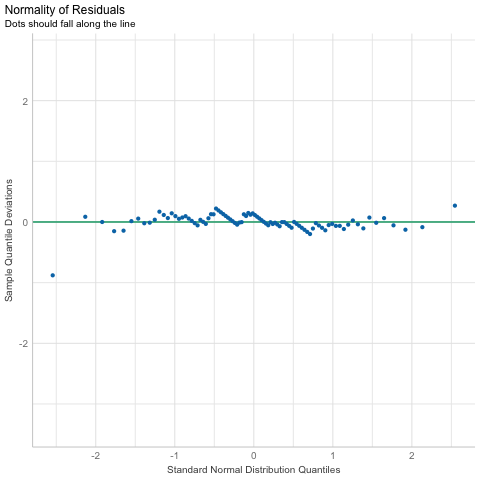

In [85]:
%%R 

library(performance) # for assumption checks

is_norm <- check_normality(o1)

#plot(is_norm)

plot(is_norm, type = "qq", detrend = TRUE)

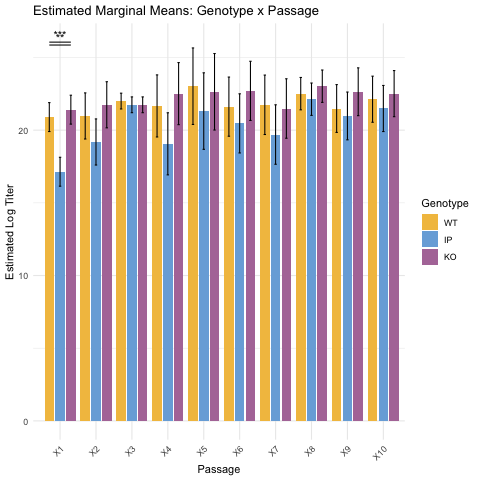

In [126]:
%%R

library(emmeans)
library(ggplot2)
library(dplyr)

# Example color palette
our_color_palette <- c("WT" = "#F2C14E",  # yellow
                       "IP" = "#79ADDC",  # blue
                       "KO" = "#B279A7")  # purple

# Pairwise comparisons of genotype at each passage level
emm_pw <- emmeans(o1, pairwise ~ genotype | passage, adjust = "bonferroni")

# Convert emmeans summary to data frame
emm_summary <- as.data.frame(summary(emm_pw$emmeans))

# Extract the p-value results from the pairwise comparisons and convert to data frame
p_value_results <- as.data.frame(summary(emm_pw$contrasts))

# Add significance levels and filter for significant differences
sig_results <- p_value_results %>%
  mutate(sig.level = case_when(
    p.value <= 0.001 ~ "***",
    p.value <= 0.01 ~ "**",
    p.value <= 0.05 ~ "*",
    TRUE ~ "ns"
  )) %>%
  filter(sig.level != "ns")

# Add genotype information to sig_results
sig_results <- sig_results %>%
  mutate(genotype1 = gsub(" - .*", "", contrast),
         genotype2 = gsub(".* - ", "", contrast))

# Calculate y-position for significance bars
max_y <- max(emm_summary$upper.CL)
sig_results <- sig_results %>%
  group_by(passage) %>%
  mutate(y.position = max_y + cumsum(0.2) * (row_number()))

# Create the plot
ggplot() +
  geom_bar(data = emm_summary, aes(x = passage, y = emmean, fill = genotype),
           stat = "identity", position = position_dodge(0.9), width = 0.8) +
  geom_errorbar(data = emm_summary, aes(x = passage, ymin = lower.CL, ymax = upper.CL, group = genotype),
                position = position_dodge(0.9), width = 0.2) +
  geom_segment(data = sig_results,
               aes(x = as.numeric(as.factor(passage)) - 0.3, 
                   xend = as.numeric(as.factor(passage)) + 0.3,
                   y = y.position, yend = y.position),
               position = position_dodge(0.9)) +
  geom_text(data = sig_results,
            aes(x = as.numeric(as.factor(passage)), y = y.position, label = sig.level),
            position = position_dodge(0.9), vjust = -0.5) +
  scale_fill_manual(values = our_color_palette) +
  labs(title = "Estimated Marginal Means: Genotype x Passage",
       x = "Passage",
       y = "Estimated Log Titer",
       fill = "Genotype") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



In [119]:
%%R
library(emmeans)
library(ggplot2)
library(dplyr)

# Pairwise comparisons of genotype at each passage level
emm_pw <- emmeans(o1, pairwise ~ genotype | passage, adjust = "bonferroni")
emm_summary <- summary(emm_pw)

# Extract the p-value results from the pairwise comparisons
p_value_results <- summary(pairs(emm_pw, by = "passage"))

# Add significance levels and filter for significant differences
sig_results <- p_value_results %>%
  mutate(sig.level = case_when(
    p.value <= 0.001 ~ "***",
    p.value <= 0.01 ~ "**",
    p.value <= 0.05 ~ "*"
  ),
  y.position = 0) %>%  # Initialize y.position
  filter(!is.na(sig.level))  # Keep only significant comparisons
sig_results

  contrast passage  estimate        SE df   t.ratio      p.value sig.level
1  WT - IP      X1  3.759362 0.5749209  6  6.538920 0.0014873810        **
2  IP - KO      X1 -4.270154 0.5749209  6 -7.427377 0.0007493551       ***
  y.position
1          0
2          0


In [121]:
%%R 

# post-ad-hoc tests
library(emmeans)
library(ggplot2)
library(dplyr)

# Pairwise comparisons of genotype at each passage level
emm_pw <- emmeans(o1, pairwise ~ passage | genotype, adjust = "bonferroni")
emm_summary <- summary(emm_pw)

# Extract the p-value results from the pairwise comparisons
p_value_results <- summary(pairs(emm_pw, by = "genotype"))

# Add significance levels and filter for significant differences
sig_results <- p_value_results %>%
  mutate(sig.level = case_when(
    p.value <= 0.001 ~ "***",
    p.value <= 0.01 ~ "**",
    p.value <= 0.05 ~ "*"
  ),
  y.position = 0) %>%  # Initialize y.position
  filter(!is.na(sig.level))  # Keep only significant comparisons
sig_results

  contrast genotype  estimate        SE df   t.ratio     p.value sig.level
1  X1 - X3       IP -4.605170 0.4766477  6 -9.661580 0.001128573        **
2  X1 - X8       IP -4.989633 0.7901047  6 -6.315155 0.010978499         *
3  X1 - X9       IP -3.838122 0.5277436  6 -7.272702 0.005288526        **
4 X1 - X10       IP -4.350152 0.8235200  6 -5.282388 0.026353501         *
5  X2 - X3       IP -2.557741 0.4897028  6 -5.223048 0.027795398         *
6 X7 - X10       IP -1.790671 0.3765632  6 -4.755301 0.042782408         *
  y.position
1          0
2          0
3          0
4          0
5          0
6          0


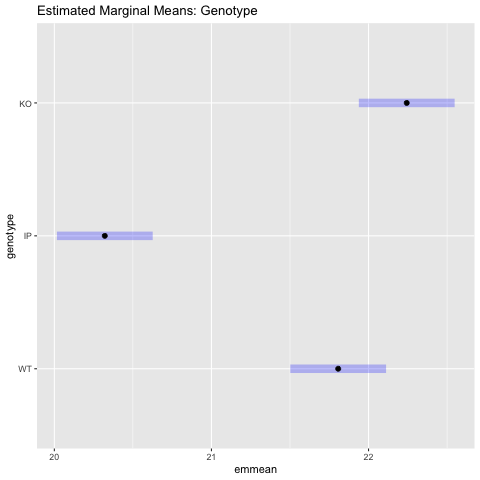

In [92]:
%%R 

library(emmeans)
library(ggplot2)
library(dplyr)

# Compute EMMs for the interaction of genotype and passage
emm_interaction <- emmeans(o1, ~ genotype * passage)

# Convert to a data frame for easier plotting
emm_df <- as.data.frame(emm_interaction)

# Create the plot
ggplot(emm_df, aes(x = passage, y = emmean, color = genotype, group = genotype)) +
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin = lower.CL, ymax = upper.CL), width = 0.2) +
  labs(title = "Estimated Marginal Means: Genotype x Passage",
       x = "Passage",
       y = "Estimated Log Titer") +
  theme_minimal()

# If you want separate plots for each factor:

# For genotype
emm_genotype <- emmeans(o1, ~ genotype)
plot(emm_genotype) + labs(title = "Estimated Marginal Means: Genotype")

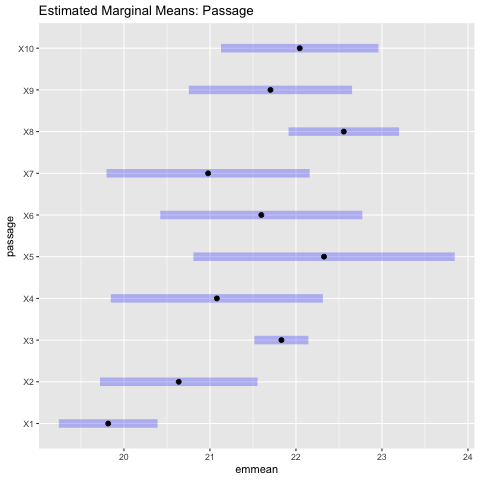

In [94]:
%%R

# For passage
emm_passage <- emmeans(o1, ~ passage)
plot(emm_passage) + labs(title = "Estimated Marginal Means: Passage")
